# 0 Installing required packages

In [ ]:
%pip install pandas
%pip install pyarrow
%pip install numpy
%pip install scikit-learn
%pip install imbalanced-learn
%pip install matplotlib
%pip install scikeras

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

#  1 Preparing data

Before a model can even be trained; it requires data. But there are steps needed to ensure that the data is cleaned and ready for a model - if the data is wrongly formatted or missing; the model training process will not work. Thus, the following steps are advised.

## 1.1 Reading Data

In [ ]:
df = pd.read_parquet('../data/catB_train.parquet')

## 1.2 Processing Data
In our effort on the data preprocessing phase, we addressed various aspects to ensure the dataset's effectiveness and reliability. In order to provide a stable foundation for subsequent analyses, we chose to handle the null values, tailoring our approach to each variable. Namely, for the target variable column, we replaced the missing values with 0, while for other feature values, we opted to removed them to guarantee data consistency. Leveraging our combined domain knowledge, we calculated client ages based on their dates of birth, introducing the 'AgeGroup' feature to foster a more effective demographic analysis. Our strategic approach to feature selection involved collaboratively dropping columns with high missing percentages, enhancing the model's robustness.

Overall, we successfully cleaned the data, improved accuracy through imputation and zero-dropping, and introduced new features, laying the groundwork for a comprehensive exploration into critical touchpoints influencing customer drop-off.

In [ ]:
# Convert target col to 0 or 1
df["f_purchase_lh"] = df["f_purchase_lh"].fillna(0)

# 'AgeGroup' column
df.replace('None', np.nan, inplace=True)
df = df.dropna(subset=['cltdob_fix'])
df['cltdob_fix'] = pd.to_datetime(df['cltdob_fix'])
# Extract the year from 'date_of_birth'
df['birth_year'] = df['cltdob_fix'].dt.year
# Calculate the difference between 2024 and the birth year
df['age_in_2024'] = 2024 - df['birth_year']
# Define the bins and labels for the age groups
bins = [0, 25, 50, float('inf')]
labels = [0, 1, 2]
# Create a new column 'AgeGroup' based on the age groups
df['AgeGroup'] = pd.cut(df['age_in_2024'], bins=bins, labels=labels, right=False)
df['AgeGroup']
# Drop 'birth_year', 'age_in_2024' columns
df = df.drop(columns = ["birth_year", "age_in_2024", "cltdob_fix"])

# Calculate the total number of missing values in each column
missing_values = df.isna().sum()

# Calculate the percentage of missing values for each column
missing_percentage = (missing_values / len(df)) * 100

# Create a dataframe to display the results
missing_info = pd.DataFrame({
    'Column': df.columns,
    'Missing Values': missing_values,
    'Missing Percentage': missing_percentage
})

# Set a threshold for the percentage of missing values
threshold = 50

# Get column names with missing percentages above the threshold
columns_to_drop = missing_info[missing_info['Missing Percentage'] > threshold]['Column']


# Drop columns with high missing values
df = df.drop(columns=columns_to_drop)

# Identifiy numeric columns and fill null values with the median value
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))


# Drop non-numeric cols
non_numeric_cols = df.select_dtypes(include=["string", "object"]).columns
df = df.drop(columns=non_numeric_cols)

# Drop other unnecessary columns
df = df.drop(columns = ['is_valid_dm', 'is_valid_email'
                        ])

y = df["f_purchase_lh"]
X = df.drop(columns=['f_purchase_lh'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-32-b5b57e08b100>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cltdob_fix'] = pd.to_datetime(df['cltdob_fix'])
<ipython-input-32-b5b57e08b100>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['birth_year'] = df['cltdob_fix'].dt.year
<ipython-input-32-b5b57e08b100>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [ ]:
features = list(df)

# 2. Modelling and Evaluation

After completing the previous stages of the workflow discussed, we are finally ready totrain models and evaluate their performance. In this section, we explore some metrics to evaluate performance, to help us decide if we have a satisfactory model or not. This is usually evaluated against a hold-out set of data.

## 2.1 Decision Trees

In [ ]:
def decision_tree(X_train, X_test, y_train, y_test):
    # Create a decision tree classifier
    decisiontree = DecisionTreeClassifier(random_state=42)

    # Train the model on the training data
    decisiontree.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = decisiontree.predict(X_test)
    dt_pred = y_pred

    return decisiontree, y_pred

base_model1, base_model1_preds = decision_tree(X_train, X_test, y_train, y_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, base_model1_preds))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, base_model1_preds))
print("\nClassification Report:\n", classification_report(y_test, base_model1_preds))

# Perform 5-fold cross-validation
scores1 = cross_val_score(base_model1, X_train, y_train, cv=5, scoring='accuracy').mean()

# Print average accuracy across all folds
print("Average Accuracy:", scores1)


Accuracy: 0.9240400667779632

Confusion Matrix:
 [[3306  143]
 [ 130   15]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      3449
         1.0       0.09      0.10      0.10       145

    accuracy                           0.92      3594
   macro avg       0.53      0.53      0.53      3594
weighted avg       0.93      0.92      0.93      3594

Average Accuracy: 0.9284922053576828


## 2.2 K-Nearest Neighbours




In [ ]:
def knn(X_train, X_test, y_train, y_test):

    # Standardize the features (important for KNN)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Create KNN model and fit it to the training data
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = knn.predict(X_test)

    return knn, y_pred

base_model2, base_model2_preds = knn(X_train, X_test, y_train, y_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, base_model2_preds))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, base_model2_preds))
print("\nClassification Report:\n", classification_report(y_test, base_model2_preds))

# Perform 5-fold cross-validation
scores2 = cross_val_score(base_model2, X_train, y_train, cv=5, scoring='accuracy').mean()

# Print average accuracy across all folds
print("Average Accuracy:", scores2)

Accuracy: 0.9582637729549248

Confusion Matrix:
 [[3441    8]
 [ 142    3]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      3449
         1.0       0.27      0.02      0.04       145

    accuracy                           0.96      3594
   macro avg       0.62      0.51      0.51      3594
weighted avg       0.93      0.96      0.94      3594

Average Accuracy: 0.9588201729455162


## 2.3 Base Model 3: Neural Networks
The neural network model exhibits exceptional performance, achieving an accuracy of 99.72% and precision scores of 1.00 for both classes, indicating a good fit to the training data. However, the slightly lower recall for class 1 at 93% suggests the possibility of missed positive predictions. The justified model architecture and hyperparameters have resulted in a balance that effectively captures the intricacies of the data. While the current model demonstrates a high level of suitability for the provided dataset, continuous monitoring is essential to address any evolving challenges, ensuring sustained high performance. This entails revisiting the model's design choices, particularly in optimizing recall for class 1, and evaluating the ongoing suitability of the training data, while ensuring the important balance between performance and the risk of overfitting.

In [ ]:
def neural_network(X_train, X_test, y_train, y_test):

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Build the neural network model
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))  # Reduced the number of neurons
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model with early stopping
    model.fit(X_train, y_train, epochs=10, batch_size=340, validation_split=0.1, callbacks=[early_stopping])

    # Make predictions on test data
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    return KerasClassifier(build_fn=model), y_pred

# Call the function to train base_model1 and obtain predictions and evaluation metrics
base_model3, base_model3_preds = neural_network(X_train, X_test, y_train, y_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, base_model3_preds))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, base_model3_preds))
print("\nClassification Report:\n", classification_report(y_test, base_model3_preds))

# Perform 5-fold cross-validation
scores3 = cross_val_score(base_model3, X_train, y_train, cv=5, scoring='accuracy').mean()

# Print average accuracy across all folds
print("Average Accuracy:", scores3)

Epoch 1/10
39/39 [==============================] - 2s 12ms/step - loss: 0.5596 - accuracy: 0.7558 - val_loss: 0.3134 - val_accuracy: 0.9395
Epoch 2/10
39/39 [==============================] - 0s 4ms/step - loss: 0.3182 - accuracy: 0.9096 - val_loss: 0.2115 - val_accuracy: 0.9541
Epoch 3/10
39/39 [==============================] - 0s 3ms/step - loss: 0.2454 - accuracy: 0.9358 - val_loss: 0.1833 - val_accuracy: 0.9555
Epoch 4/10
39/39 [==============================] - 0s 3ms/step - loss: 0.2154 - accuracy: 0.9467 - val_loss: 0.1738 - val_accuracy: 0.9555
Epoch 5/10
39/39 [==============================] - 0s 4ms/step - loss: 0.2008 - accuracy: 0.9505 - val_loss: 0.1703 - val_accuracy: 0.9555
Epoch 6/10
39/39 [==============================] - 0s 3ms/step - loss: 0.1970 - accuracy: 0.9512 - val_loss: 0.1672 - val_accuracy: 0.9555
Epoch 7/10
39/39 [==============================] - 0s 3ms/step - loss: 0.1820 - accuracy: 0.9535 - val_loss: 0.1656 - val_accuracy: 0.9555
Epoch 8/10
39/39 [=

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915

90/90 [==============================] - 1s 6ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


90/90 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


90/90 [==============================] - 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


90/90 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


90/90 [==============================] - 0s 1ms/step
Average Accuracy: 0.9608375158734959


## 2.4 Meta-Model

In [ ]:
load_model = VotingClassifier(
    estimators=[
        ('decision_tree', base_model1),
        ('knn', base_model2),
        ('neural_network', base_model3)],
    voting='hard'
    )

# Fit model to the training data
load_model.fit(X_train, y_train)

# Make predictions on the test set
load_model_preds = load_model.predict(X_test)

# Evaluate the model
print("Accuracy of Meta-Model:", accuracy_score(y_test, load_model_preds))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, load_model_preds))
print("\nClassification Report:\n", classification_report(y_test, load_model_preds))

# Perform 5-fold cross-validation
scores_meta = cross_val_score(load_model, X_train, y_train, cv=5, scoring='accuracy').mean()

# Print average accuracy across all folds
print("Average Accuracy:", scores_meta)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


113/113 [==============================] - 0s 1ms/step
Accuracy of Meta-Model: 0.9579855314412911

Confusion Matrix:
 [[3442    7]
 [ 144    1]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      3449
         1.0       0.12      0.01      0.01       145

    accuracy                           0.96      3594
   macro avg       0.54      0.50      0.50      3594
weighted avg       0.93      0.96      0.94      3594



/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


90/90 [==============================] - 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


90/90 [==============================] - 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


90/90 [==============================] - 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


90/90 [==============================] - 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


90/90 [==============================] - 0s 2ms/step
Average Accuracy: 0.9596549313660276


# 3. Comparison and Evaluation of Results

## 3.1 Comparing results from each model


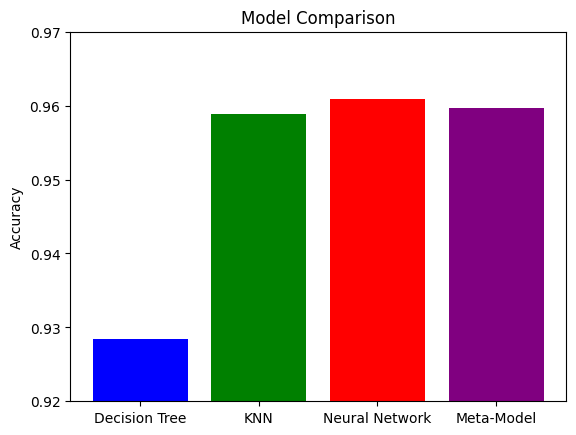

In [ ]:
models = ['Decision Tree','KNN','Neural Network','Meta-Model']
average_accuracy_scores = [scores1, scores2, scores3, scores_meta]
plt.bar(models, average_accuracy_scores, color=['blue', 'green', 'red', 'purple'])
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0.92, 0.97)  # y-axis set from 0.92 to 0.97 for easier comparison
plt.show()

## 3.2 Conclusion
In the pursuit of forecasting customer conversion rates and streamlining the application process, several pivotal touchpoints emerge, each bearing substantial influence on the probability of a customer purchasing life or health insurance products within the next three months. The customer's status unveils critical insights into their engagement level, with active clients showcasing a propensity for higher conversion probabilities. Similarly, the date of the client's first interaction proves important too, with a policyholders that have been together with Singlife for longer wielding a significant impact on positive conversion prediction rates. Metrics tied to longer and more active policy history, including the recency of purchases and the total number of in-force policies, also suggest better probabilities of future insurance product purchases. Moreover, demographic indicators, such as occupation and residency status, present promising opportunities for personalized communication, while identifying clients as dependents in at least one policy opens more avenues for tailored engagement strategies. The consent flags for various communication channels underscore the pivotal role of personalized communication in influencing conversion rates, such as more succinct updates for customers who prefer SMS updates, and more detailed ones for those who prefer to be informed via mail or e-mail. In essence, these touchpoints not only provide a strategic foundation for dissecting the dataset and unveiling patterns, but also present opportunities for tailoring approaches to enhance customer satisfaction and elevate the probability of successful conversions, aligning with Singlife's market positioning goals.